In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# a) clone from github repo directly
!git clone https://github.com/location-competition/indoor-location-competition-20
!mv ./indoor-location-competition-20/* ./

Cloning into 'indoor-location-competition-20'...
remote: Enumerating objects: 1181, done.
remote: Total 1181 (delta 0), reused 0 (delta 0), pack-reused 1181
Receiving objects: 100% (1181/1181), 411.37 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (1145/1145), done.


In [3]:
from pathlib import Path
import json
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt

### compute_f.py

In [4]:
# this cell contains the content from compute_f.py
import numpy as np
import scipy.signal as signal


def split_ts_seq(ts_seq, sep_ts):
    """

    :param ts_seq:
    :param sep_ts:
    :return:
    """
    tss = ts_seq[:, 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs = []
    start_index = 0
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side='right')
        if start_index == end_index:
            continue
        ts_seqs.append(ts_seq[start_index:end_index, :].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index:, :].copy())

    return ts_seqs


def correct_trajectory(original_xys, end_xy):
    """

    :param original_xys: numpy ndarray, shape(N, 2)
    :param end_xy: numpy ndarray, shape(1, 2)
    :return:
    """
    corrected_xys = np.zeros((0, 2))

    A = original_xys[0, :]
    B = end_xy
    Bp = original_xys[-1, :]

    angle_BAX = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB = angle_BpAX - angle_BAX
    AB = np.sqrt(np.sum((B - A) ** 2))
    ABp = np.sqrt(np.sum((Bp - A) ** 2))

    corrected_xys = np.append(corrected_xys, [A], 0)
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])

        angle_CAX = angle_CpAX - angle_BpAB

        ACp = np.sqrt(np.sum((original_xys[i, :] - A) ** 2))

        AC = ACp * AB / ABp

        delta_C = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])

        C = delta_C + A

        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys


def correct_positions(rel_positions, reference_positions):
    """

    :param rel_positions:
    :param reference_positions:
    :return:
    """
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[:, 0])
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
    assert len(rel_positions_list) == reference_positions.shape[0] - 1

    corrected_positions = np.zeros((0, 3))
    for i, rel_ps in enumerate(rel_positions_list):
        start_position = reference_positions[i]
        end_position = reference_positions[i + 1]
        abs_ps = np.zeros(rel_ps.shape)
        abs_ps[:, 0] = rel_ps[:, 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1:3] = rel_ps[0, 1:3] + start_position[1:3]
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1:3] = abs_ps[j-1, 1:3] + rel_ps[j, 1:3]
        abs_ps = np.insert(abs_ps, 0, start_position, axis=0)
        corrected_xys = correct_trajectory(abs_ps[:, 1:3], end_position[1:3])
        corrected_ps = np.column_stack((abs_ps[:, 0], corrected_xys))
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis=0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1:], axis=0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions


def init_parameters_filter(sample_freq, warmup_data, cut_off_freq=2):
    order = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf = signal.lfilter_zi(filter_b, filter_a)
    _, zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)
    _, filter_zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)

    return filter_b, filter_a, filter_zf


def get_rotation_matrix_from_vector(rotation_vector):
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1*q1 - q2*q2 - q3*q3
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0

    R = np.zeros((9,))
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0

        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0

        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2

        R = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = 0.0

        R[4] = q1_q2 + q3_q0
        R[5] = 1 - sq_q1 - sq_q3
        R[6] = q2_q3 - q1_q0
        R[7] = 0.0

        R[8] = q1_q3 - q2_q0
        R[9] = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0

        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0

        R = np.reshape(R, (4, 4))

    return R


def get_orientation(R):
    flat_R = R.flatten()
    values = np.zeros((3,))
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values


def compute_steps(acce_datas):
    step_timestamps = np.array([])
    step_indexs = np.array([], dtype=int)
    step_acce_max_mins = np.zeros((0, 4))
    sample_freq = 50
    window_size = 22
    low_acce_mag = 0.6
    step_criterion = 1
    interval_threshold = 250

    acce_max = np.zeros((2,))
    acce_min = np.zeros((2,))
    acce_binarys = np.zeros((window_size,), dtype=int)
    acce_mag_pre = 0
    state_flag = 0

    warmup_data = np.ones((window_size,)) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data = acce_datas[i, :]
        acce_mag = np.sqrt(np.sum(acce_data[1:] ** 2))

        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi=filter_zf)
        acce_mag_filt = acce_mag_filt[0]

        acce_mag_window = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window = np.delete(acce_mag_window, 0)
        mean_gravity = np.mean(acce_mag_window)
        acce_std = np.std(acce_mag_window)
        mag_threshold = np.max([low_acce_mag, 0.4 * acce_std])

        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend = acce_mag_filt - mean_gravity
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1
            elif (state_flag == 1) and ((acce_data[0] - acce_max[0]) <= interval_threshold) and (
                    acce_mag_filt > acce_max[1]):
                acce_max[:] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and (np.sum(acce_binarys[:-2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[:] = acce_data[0], acce_mag_filt
                    state_flag = 2
                    step_flag = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and (
                        acce_mag_filt < acce_min[1]):
                    acce_min[:] = acce_data[0], acce_mag_filt
        if step_flag:
            step_timestamps = np.append(step_timestamps, acce_data[0])
            step_indexs = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], acce_min[1], acce_std ** 2]], axis=0)
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins


def compute_stride_length(step_acce_max_mins):
    K = 0.4
    K_max = 0.8
    K_min = 0.4
    para_a0 = 0.21468084
    para_a1 = 0.09154517
    para_a2 = 0.02301998

    stride_lengths = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[:, 0] = step_acce_max_mins[:, 0]
    window_size = 2
    step_timeperiod_temp = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[:, 0] = step_acce_max_mins[:, 0]
    k_real[0, 1] = K
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] + para_a2 * step_acce_max_mins[i, 3]), K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[:, 1] = np.max([(step_acce_max_mins[:, 1] - step_acce_max_mins[:, 2]),
                                   np.ones((step_acce_max_mins.shape[0], ))], axis=0)**(1 / 4) * k_real[:, 1]

    return stride_lengths


def compute_headings(ahrs_datas):
    headings = np.zeros((np.size(ahrs_datas, 0), 2))
    for i in np.arange(0, np.size(ahrs_datas, 0)):
        ahrs_data = ahrs_datas[i, :]
        rot_mat = get_rotation_matrix_from_vector(ahrs_data[1:])
        azimuth, pitch, roll = get_orientation(rot_mat)
        around_z = (-azimuth) % (2 * np.pi)
        headings[i, :] = ahrs_data[0], around_z
    return headings


def compute_step_heading(step_timestamps, headings):
    step_headings = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, :] = headings[i, :]
                step_timestamps_index += 1
        else:
            break
    assert step_timestamps_index == len(step_timestamps)

    return step_headings


def compute_rel_positions(stride_lengths, step_headings):
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions


def compute_step_positions(acce_datas, ahrs_datas, posi_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    step_positions = correct_positions(rel_positions, posi_datas)

    return step_positions


### iBeacon RSSI

In [6]:
# load data:
floor_info = '/site1/F1'
floor_data_dir = './data' + floor_info
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'

save_dir = './output/site1/B1'
path_image_save_dir = save_dir + '/path_images'
ibeacon_image_save_dir = save_dir + '/ibeacon_images'

# Path(path_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(ibeacon_image_save_dir).mkdir(parents=True, exist_ok=True)

with open(floor_info_filename) as f:
  floor_info = json.load(f)

width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

In [30]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)


In [31]:
def calibrate_magnetic_wifi_ibeacon_to_position(path_file_list):
    mwi_datas = {}
    for path_filename in path_file_list:
        print(f'Processing {path_filename}...')

        path_datas = read_data_file(path_filename)
        acce_datas = path_datas.acce
        magn_datas = path_datas.magn
        ahrs_datas = path_datas.ahrs
        wifi_datas = path_datas.wifi
        ibeacon_datas = path_datas.ibeacon
        posi_datas = path_datas.waypoint

        step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
        # visualize_trajectory(posi_datas[:, 1:3], floor_plan_filename, width_meter, height_meter, title='Ground Truth', show=True)
        # visualize_trajectory(step_positions[:, 1:3], floor_plan_filename, width_meter, height_meter, title='Step Position', show=True)

        if wifi_datas.size != 0:
            sep_tss = np.unique(wifi_datas[:, 0].astype(float))
            wifi_datas_list = split_ts_seq(wifi_datas, sep_tss)
            for wifi_ds in wifi_datas_list:
                diff = np.abs(step_positions[:, 0] - float(wifi_ds[0, 0]))
                index = np.argmin(diff)
                target_xy_key = tuple(step_positions[index, 1:3])
                if target_xy_key in mwi_datas:
                    mwi_datas[target_xy_key]['wifi'] = np.append(mwi_datas[target_xy_key]['wifi'], wifi_ds, axis=0)
                else:
                    mwi_datas[target_xy_key] = {
                        'magnetic': np.zeros((0, 4)),
                        'wifi': wifi_ds,
                        'ibeacon': np.zeros((0, 3))
                    }

        if ibeacon_datas.size != 0:
            sep_tss = np.unique(ibeacon_datas[:, 0].astype(float))
            ibeacon_datas_list = split_ts_seq(ibeacon_datas, sep_tss)
            for ibeacon_ds in ibeacon_datas_list:
                diff = np.abs(step_positions[:, 0] - float(ibeacon_ds[0, 0]))
                index = np.argmin(diff)
                target_xy_key = tuple(step_positions[index, 1:3])
                if target_xy_key in mwi_datas:
                    mwi_datas[target_xy_key]['ibeacon'] = np.append(mwi_datas[target_xy_key]['ibeacon'], ibeacon_ds, axis=0)
                else:
                    mwi_datas[target_xy_key] = {
                        'magnetic': np.zeros((0, 4)),
                        'wifi': np.zeros((0, 5)),
                        'ibeacon': ibeacon_ds
                    }

        sep_tss = np.unique(magn_datas[:, 0].astype(float))
        magn_datas_list = split_ts_seq(magn_datas, sep_tss)
        for magn_ds in magn_datas_list:
            diff = np.abs(step_positions[:, 0] - float(magn_ds[0, 0]))
            index = np.argmin(diff)
            target_xy_key = tuple(step_positions[index, 1:3])
            if target_xy_key in mwi_datas:
                mwi_datas[target_xy_key]['magnetic'] = np.append(mwi_datas[target_xy_key]['magnetic'], magn_ds, axis=0)
            else:
                mwi_datas[target_xy_key] = {
                    'magnetic': magn_ds,
                    'wifi': np.zeros((0, 5)),
                    'ibeacon': np.zeros((0, 3))
                }

    return mwi_datas

In [32]:
def get_ibeacon_rssi(mwi_datas):
    ibeacon_rssi = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')

        ibeacon_data = mwi_datas[position_key]['ibeacon']
        for ibeacon_d in ibeacon_data:
            ummid = ibeacon_d[1]
            rssi = int(ibeacon_d[2])

            if ummid in ibeacon_rssi:
                position_rssi = ibeacon_rssi[ummid]
                if position_key in position_rssi:
                    old_rssi = position_rssi[position_key][0]
                    old_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (old_rssi * old_count + rssi) / (old_count + 1)
                    position_rssi[position_key][1] = old_count + 1
                else:
                    position_rssi[position_key] = np.array([rssi, 1])
            else:
                position_rssi = {}
                position_rssi[position_key] = np.array([rssi, 1])

            ibeacon_rssi[ummid] = position_rssi

    return ibeacon_rssi

In [ ]:
# visualize heatmap

In [33]:
# 1. visualize ground truth positions
print("Visualizing ground truth positions...")
for path_filename in path_filenames:
    print(f'Processing file: {path_filename}...')
    path_data = read_data_file(path_filename)

print('Visualizing more information...')
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position(path_filenames)


Visualizing ground truth positions...
Processing file: /content/data/site1/F1/path_data_files/5dd9efa7c5b77e0006b17367.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9e7d29191710006b57071.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9ef959191710006b57084.txt...
Processing file: /content/data/site1/F1/path_data_files/5dda021e9191710006b57114.txt...
Processing file: /content/data/site1/F1/path_data_files/5dda021c9191710006b57112.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9fd489191710006b570dc.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9e7c79191710006b57067.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9fd60c5b77e0006b173dc.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9fd549191710006b570e6.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9e7abc5b77e0006b1732d.txt...
Processing file: /content/data/site1/F1/path_data_files/5dd9e7c29191710006b57061.t

This floor has20 ibeacons
Example 10 ibeacon UUID_MajorID_MinorIDs:

9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0
FDA50693-A4E2-4FB1-AFCF-C6EB07647825_10073_61418
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_45850_14031
616C6970-6179-626F-7869-626561636F6A_28214_49911
616C6970-6179-626F-7869-626561636F6A_49662_37272
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_47237_15305
3C3493F1-997A-D187-0AD6-FB5A8D4EFA63_30242_6415
48F8C9EF-AEF9-482D-987F-3752F1C51DA1_22_40969
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_19018_35270
6B76E28A-6FA2-48C9-8502-C1DAA388AB2C_45101_52752
Please input target ibeacon UUID_MajorID_MinorID:
9195B3AD-A9D0-4500-85FF-9FB0F65A5201_0_0


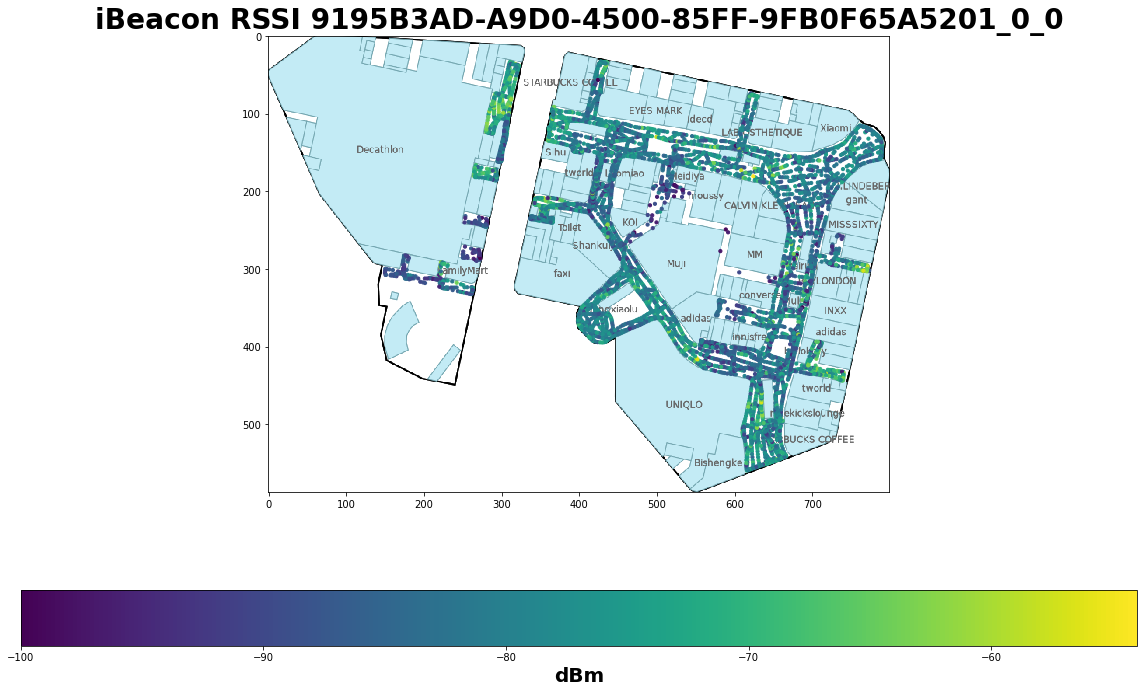

In [74]:
# iBeacon RSSI
ibeacon_rssi = get_ibeacon_rssi(mwi_datas)
print(f'This floor has{len(ibeacon_rssi.keys())} ibeacons')
ten_ibeacon_ummids = list(ibeacon_rssi.keys())[0:10]
print('Example 10 ibeacon UUID_MajorID_MinorIDs:\n')
for ummid in ten_ibeacon_ummids:
  print(ummid)
target_ibeacon = input(f"Please input target ibeacon UUID_MajorID_MinorID:\n")
ibeacon_heatpositions = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
ibeacon_heatvalues = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:,0]

# plot ibeacon heatmap
image = plt.imread(floor_plan_filename)
plt.figure(figsize=(20, 12))
implot = plt.imshow(image)
plt.title('iBeacon RSSI ' + target_ibeacon, fontsize=28, weight='bold')

scaleFactor = (image.shape[0] / height_meter + image.shape[1] / width_meter)/2

# Get x and y coordinates
x = ibeacon_heatpositions[:,0]
y = ibeacon_heatpositions[:,1]
x, y = np.array(x), np.array(y)

x, y = x * scaleFactor, image.shape[0] - y * scaleFactor

plt.scatter(x, y, s = 10, c = ibeacon_heatvalues, cmap = 'viridis')
colorBar = plt.colorbar(cmap='viridis', orientation="horizontal").set_label(label='dBm',size=20, weight='bold')


# plt.savefig(ibeacon_image_save_dir + '/iBeaconHeatMap.png')
plt.show()

In [ ]:
# # iBeacon RSSI
# ibeacon_rssi = get_ibeacon_rssi(mwi_datas)
# print(f'This floor has{len(ibeacon_rssi.keys())} ibeacons')
# ten_ibeacon_ummids = list(ibeacon_rssi.keys())[0:10]
# print('Example 10 ibeacon UUID_MajorID_MinorIDs:\n')
# for ummid in ten_ibeacon_ummids:
#   print(ummid)
# target_ibeacon = input(f"Please input target ibeacon UUID_MajorID_MinorID:\n")
# heat_positions = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
# heat_values = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:,0]
# ibeacon_fig = visualize_heatmap(heat_positions, heat_values, floor_plan_filename, width_meter, height_meter, colorbar_title='dBm', title=f'iBeacon {target_ibeacon} RSSI', show=True)
# html_filename = f'{ibeacon_image_save_dir}/{target_ibeacon}.html'
# html_filename = str(Path(html_filename).resolve())
# ibeacon_fig.write_html(html_filename)